In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer

from data import (
    tfrecord_labeled_dataset,
    tfrecord_dataset,
    normalize,
    normalize_labeled,
    train_test_split,
    kfolds,
)
from layers import SeluConv3D, SeluDense
from plot import plot_slice, plot_volume_animation, plot_loss_history, plot_regression_results
from config import (
    CT_0_TFRECORD,
    CT_1_TFRECORD,
    CT_2_TFRECORD,
    CT_3_TFRECORD,
    CT_4_TFRECORD,
    COVID_NEG_TFRECORD,
    COVID_POS_TFRECORD,
    SCAN_SHAPE,
    COVID_SCAN_SHAPE,
    LIDC_TOT_NUM_NODULES_TFRECORD,
    LIDC_NUM_BIG_NODULES_TFRECORD,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]
matplotlib.rcParams.update({"font.size": 15})

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# LIDC dataset

In [ ]:
def scaler(x, label):
    def numpy_transform(x):
        qt = QuantileTransformer()
        raw = qt.fit_transform(x.reshape((-1, 1))).reshape(x.shape)
        return 1 / (1 + np.exp(-(raw - 0.7) / 0.2))

    scaled_x = tf.numpy_function(numpy_transform, [x], tf.float32)
    scaled_x.set_shape(SCAN_SHAPE)
    return scaled_x, label

In [ ]:
"""
Load the LIDC dataset. Its elements are of the form:
    (scan, number_of_nodules)

Where scan is a 3D volume of size (64, 192, 224, 1)
"""
lidc_dataset = (
    tfrecord_labeled_dataset(LIDC_TOT_NUM_NODULES_TFRECORD)
    # .map(normalize_labeled, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(scaler, num_parallel_calls=tf.data.experimental.AUTOTUNE)
)
# lidc_samples = sum(1 for _ in tqdm(lidc_dataset))
lidc_samples = 1010
print(f"{lidc_samples = }")
lidc_dataset

In [ ]:
"""
Run this to have an idea of the elements of the lidc_dataset.
"""
scan, num_nodules = next(iter(lidc_dataset))
print(f"{num_nodules = }")
print(scan.shape)
plot_volume_animation(scan)

In [ ]:
def build_regression_model():
    model = keras.Sequential(
        [
            keras.layers.InputLayer(SCAN_SHAPE, name="input_layer"),
            SeluConv3D(filters=32, kernel_size=3, name="selu_conv3d_1"),
            keras.layers.MaxPool3D(2, name="maxpool3d_1"),
            SeluConv3D(filters=64, kernel_size=3, name="selu_conv3d_2"),
            keras.layers.MaxPool3D(2, name="maxpool3d_2"),
            SeluConv3D(filters=128, kernel_size=3, name="selu_conv3d_3"),
            keras.layers.MaxPool3D(2, name="maxpool3d_3"),
            SeluConv3D(filters=256, kernel_size=3, name="selu_conv3d_4"),
            keras.layers.MaxPool3D(2, name="maxpool3d_4"),
            keras.layers.Flatten(name="flatten"),
            keras.layers.Dense(1, name="final_dense"),
        ],
        name="3d_cnn",
    )
    return model


m = build_regression_model()
m.summary()

In [ ]:
val_perc = 0.2
learning_rate = 1e-5
batch_size = 8
patience = 15

In [ ]:
train_dataset, val_dataset = train_test_split(
    lidc_dataset, test_perc=val_perc, cardinality=lidc_samples
)
val_dataset = (
    val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
"""
Train a regression model for the number of nodules on the LIDC dataset.
Save the final model in models/lidc-num-nodules-3dcnn.h5
"""
cnn = build_regression_model()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
)
history = cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
        ),
    ],
)
cnn.save("models/lidc-num-nodules-3dcnn.h5")

In [ ]:
"Plot the train and validation loss of the previous training"
plot_loss_history(history)
# plt.savefig("num-nodules-regression-loss.pdf")

In [ ]:
"Print the number of nodules and its regression prediction on the validation set"
# cnn = keras.models.load_model("models/")
for x, y in val_dataset.unbatch().batch(1).as_numpy_iterator():
    print(f"real: {y}")
    print(f"predicted: {cnn(x, training=False).numpy()}")
    print()

 # Covid dataset

In [ ]:
def scaler(x):
    def numpy_transform(x):
        qt = QuantileTransformer()
        raw = qt.fit_transform(x.reshape((-1, 1))).reshape(x.shape)
        return 1 / (1 + np.exp(-(raw - 0.7) / 0.2))

    scaled_x = tf.numpy_function(numpy_transform, [x], tf.float32)
    scaled_x.set_shape(SCAN_SHAPE)
    return scaled_x

In [48]:
neg_x = tfrecord_dataset([CT_0_TFRECORD]).map(
    normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
# neg_samples = sum(1 for _ in tqdm(neg_x))
neg_samples = 254  # CT-0
print(f"{neg_samples = }")
neg_dataset = tf.data.Dataset.zip(
    (neg_x, tf.data.Dataset.from_tensor_slices(np.int8([[0]])).repeat(neg_samples))
)
# assert sum(1 for _ in tqdm(neg_dataset)) == neg_samples

pos_x = tfrecord_dataset(
    #[CT_1_TFRECORD, CT_2_TFRECORD, CT_3_TFRECORD, CT_4_TFRECORD]
    [CT_4_TFRECORD]
).map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# pos_samples = sum(1 for _ in tqdm(pos_x))
pos_samples = 856  # CT-1 + CT-2 + CT-3 + CT-4
# pos_samples = 127  # CT-2 + CT-3 + CT-4
print(f"{pos_samples = }")
pos_dataset = tf.data.Dataset.zip(
    (pos_x, tf.data.Dataset.from_tensor_slices(np.int8([[1]])).repeat(pos_samples))
)
# assert sum(1 for _ in tqdm(pos_dataset)) == pos_samples

covid_dataset = neg_dataset.concatenate(pos_dataset)
covid_samples = neg_samples + pos_samples
# assert sum(1 for _ in tqdm(covid_dataset)) == covid_samples
print(f"{covid_samples = }")
covid_dataset

neg_samples = 254
pos_samples = 856
covid_samples = 1110


<ConcatenateDataset shapes: ((None, None, None, None), (1,)), types: (tf.float32, tf.int8)>

label = <tf.Tensor: shape=(1,), dtype=int8, numpy=array([1], dtype=int8)>


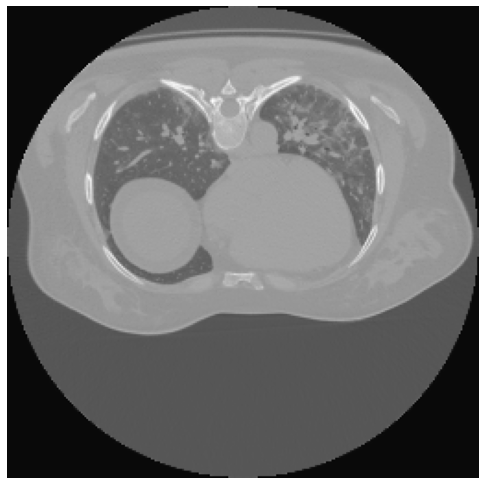

In [53]:
"""
Run this to have an idea of the elements of the covid_dataset.
At this point, covid_dataset is not shuffled, so the elements are
in order CT-0, CT-1, CT-2, CT-3, CT-4.

For example, to see a CT-2 scan you must run .skip(950)
"""
scan, label = next(iter(covid_dataset.skip(254)))
print(f"{label = }")
#plot_volume_animation(scan)
plot_slice(scan, index=23)
plt.axis("off")
plt.tight_layout()
plt.savefig("ct-4.pdf")

In [12]:
ef build_3d_cnn():
    model = keras.Sequential(
        [
            keras.layers.InputLayer(COVID_SCAN_SHAPE, name="input_layer"),
            SeluConv3D(filters=32, kernel_size=3, name="selu_conv3d_1"),
            keras.layers.MaxPool3D(2, name="maxpool3d_1"),
            SeluConv3D(filters=64, kernel_size=3, name="selu_conv3d_2"),
            keras.layers.MaxPool3D(2, name="maxpool3d_2"),
            SeluConv3D(filters=128, kernel_size=3, name="selu_conv3d_3"),
            keras.layers.MaxPool3D(2, name="maxpool3d_3"),
            SeluConv3D(filters=256, kernel_size=3, name="selu_conv3d_4"),
            keras.layers.MaxPool3D(2, name="maxpool3d_4"),
            keras.layers.Flatten(name="flatten"),
            keras.layers.Dense(1, activation="sigmoid", name="final_dense"),
        ],
        name="3d_cnn",
    )
    return model


m = build_3d_cnn()
m.summary()

Model: "3d_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
selu_conv3d_1 (Conv3D)       (None, 42, 256, 256, 32)  896       
_________________________________________________________________
maxpool3d_1 (MaxPooling3D)   (None, 21, 128, 128, 32)  0         
_________________________________________________________________
selu_conv3d_2 (Conv3D)       (None, 21, 128, 128, 64)  55360     
_________________________________________________________________
maxpool3d_2 (MaxPooling3D)   (None, 10, 64, 64, 64)    0         
_________________________________________________________________
selu_conv3d_3 (Conv3D)       (None, 10, 64, 64, 128)   221312    
_________________________________________________________________
maxpool3d_3 (MaxPooling3D)   (None, 5, 32, 32, 128)    0         
_________________________________________________________________
selu_conv3d_4 (Conv3D)       (None, 5, 32, 32, 256)    88499

In [ ]:
def build_pretrained_3d_cnn(freezing=True):
    pretrained_3d_cnn = keras.models.load_model("models/lidc-num-nodules-3dcnn.h5")
    pretrained_3d_cnn.pop()  # remove last dense layer
    model = keras.Sequential(
        [
            keras.layers.InputLayer(SCAN_SHAPE, name="pretrained_input"),
            pretrained_3d_cnn,
            keras.layers.Dense(1, activation="sigmoid", name="final_dense"),
        ],
        name="pretrained_3d_cnn",
    )
    pretrained_3d_cnn.trainable = not freezing
    return model


m = build_pretrained_3d_cnn()
m.summary()

In [13]:
test_perc = 0.1
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
patience = 15

In [14]:
trainval_dataset, test_dataset = train_test_split(
    covid_dataset, test_perc=test_perc, cardinality=covid_samples
)
train_dataset, val_dataset = train_test_split(trainval_dataset, test_perc=val_perc)
test_dataset = test_dataset.batch(1)
val_dataset = (
    val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [15]:
"Train a model to predict covid/non-covid"
cnn = build_3d_cnn()
# cnn = build_pretrained_3d_cnn()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.AUC(name="auc"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)
history = cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
        ),
    ],
)

Epoch 1/1000
113/113 [==============================] - 63s 558ms/step - loss: 0.5440 - tp: 682.0000 - fp: 204.0000 - tn: 1.0000 - fn: 13.0000 - precision: 0.7698 - recall: 0.9813 - auc: 0.5064 - accuracy: 0.7589 - val_loss: 0.5265 - val_tp: 78.0000 - val_fp: 21.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.7879 - val_recall: 1.0000 - val_auc: 0.5085 - val_accuracy: 0.7879
Epoch 2/1000
113/113 [==============================] - 46s 409ms/step - loss: 0.5408 - tp: 695.0000 - fp: 205.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.7722 - recall: 1.0000 - auc: 0.5192 - accuracy: 0.7722 - val_loss: 0.5265 - val_tp: 78.0000 - val_fp: 21.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.7879 - val_recall: 1.0000 - val_auc: 0.5092 - val_accuracy: 0.7879
Epoch 3/1000
113/113 [==============================] - 47s 415ms/step - loss: 0.5405 - tp: 695.0000 - fp: 205.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.7722 - recall: 1.0000 - auc: 0.5198 

Epoch 22/1000
113/113 [==============================] - 47s 417ms/step - loss: 0.4775 - tp: 671.0000 - fp: 80.0000 - tn: 125.0000 - fn: 24.0000 - precision: 0.8935 - recall: 0.9655 - auc: 0.8203 - accuracy: 0.8844 - val_loss: 0.5315 - val_tp: 63.0000 - val_fp: 11.0000 - val_tn: 10.0000 - val_fn: 15.0000 - val_precision: 0.8514 - val_recall: 0.8077 - val_auc: 0.5818 - val_accuracy: 0.7374
Epoch 23/1000
113/113 [==============================] - 47s 415ms/step - loss: 0.4770 - tp: 669.0000 - fp: 78.0000 - tn: 127.0000 - fn: 26.0000 - precision: 0.8956 - recall: 0.9626 - auc: 0.8235 - accuracy: 0.8844 - val_loss: 0.5296 - val_tp: 66.0000 - val_fp: 16.0000 - val_tn: 5.0000 - val_fn: 12.0000 - val_precision: 0.8049 - val_recall: 0.8462 - val_auc: 0.5620 - val_accuracy: 0.7172
Epoch 24/1000
113/113 [==============================] - 47s 414ms/step - loss: 0.4751 - tp: 672.0000 - fp: 77.0000 - tn: 128.0000 - fn: 23.0000 - precision: 0.8972 - recall: 0.9669 - auc: 0.8362 - accuracy: 0.8889 - 

<module 'matplotlib.pyplot' from '/home/emilio/venv38/lib64/python3.8/site-packages/matplotlib/pyplot.py'>

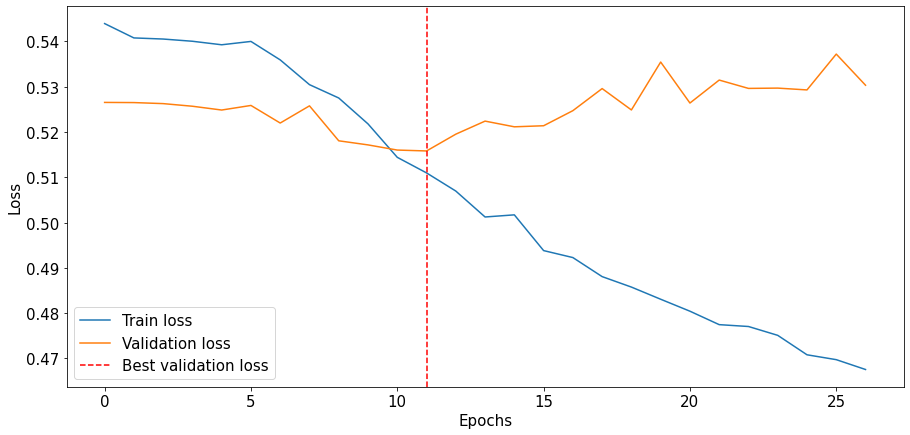

In [16]:
plot_loss_history(history)

In [17]:
print(cnn.evaluate(test_dataset, return_dict=True))

111/111 [==============================] - 3s 25ms/step - loss: 0.5587 - tp: 81.0000 - fp: 28.0000 - tn: 0.0000e+00 - fn: 2.0000 - precision: 0.7431 - recall: 0.9759 - auc: 0.6478 - accuracy: 0.7297
{'loss': 0.5586776733398438, 'tp': 81.0, 'fp': 28.0, 'tn': 0.0, 'fn': 2.0, 'precision': 0.7431192398071289, 'recall': 0.9759036302566528, 'auc': 0.6478054523468018, 'accuracy': 0.7297297120094299}


In [ ]:
rounds = 5
fracs = (1, 2, 5, 7, 10)
test_perc = 0.1
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
patience = 10
num_epochs = 1000
metrics = [
    keras.metrics.AUC(name="auc", num_thresholds=1000),
]

In [ ]:
"""
Train a model from scratch and a pre-trained model on the covid_dataset.

The models are trained on 1/`fracs` of the original covid_dataset.
The process is repeated r `rounds`.
"""
data = defaultdict(list)
wo_pt_histories = []
w_pt_histories = []
w_pt_freezing_histories = []
for r in tqdm(range(rounds)):
    print(f" {r = } ".center(50, "="))
    full_train_dataset, test_dataset = train_test_split(
        covid_dataset, test_perc=test_perc, cardinality=covid_samples
    )
    # print(f"Test size: {sum(1 for _ in test_dataset)}")
    test_dataset = test_dataset.batch(batch_size)
    full_train_dataset, val_dataset = train_test_split(
        full_train_dataset, test_perc=val_perc
    )
    # print(f"Val size: {sum(1 for _ in val_dataset)}")
    val_dataset = val_dataset.batch(batch_size)
    wo_pt_frac_histories = []
    w_pt_frac_histories = []
    w_pt_freezing_frac_histories = []
    for frac in fracs:
        print(f" {frac = } ".center(25, "="))
        train_dataset = (
            full_train_dataset.shuffle(1024, reshuffle_each_iteration=False)
            .shard(num_shards=frac, index=0)
            .cache()  # must be called before shuffle
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )
        # print(f"Train size: {sum(1 for _ in train_dataset.unbatch())}")

        cnn = build_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        wo_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        wo_pt_auc = test_metrics["auc"]
        print(f"{wo_pt_auc = }")
        data["nn_type"].append("w/o pre-training")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(wo_pt_auc)

        cnn = build_pretrained_3d_cnn(freezing=False)
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        w_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        w_pt_auc = test_metrics["auc"]
        print(f"{w_pt_auc = }")
        data["nn_type"].append("w/ pre-training (w/o freezing)")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(w_pt_auc)

    wo_pt_histories.append(wo_pt_frac_histories)
    w_pt_histories.append(w_pt_frac_histories)

In [ ]:
"Plot the results of the previous trainings"
g = sns.catplot(
    x="train_size_fraction",
    y="metric_value",
    col="metric",
    hue="nn_type",
    kind="point",
    data=pd.DataFrame(data),
)
# for ax in g.axes[0]:
#    ax.axhline(color="r", ls="--")

In [ ]:
round_index = 0
frac_index = 0
plt.plot(
    wo_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/o pre-training - train loss",
)
plt.plot(
    wo_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/o pre-training - val loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/ pre-training, w/o conv freezing - train loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/ pre-training, w/o conv freezing - val loss",
)
# plt.plot(
#    w_pt_freezing_histories[round_index][frac_index].history["loss"],
#    "--",
#    label="w/ pre-training, w/ conv freezing - train loss",
# )
# plt.plot(
#    w_pt_freezing_histories[round_index][frac_index].history["val_loss"],
#    label="w/ pre-training, w/ conv freezing - val loss",
# )
plt.legend()

In [ ]:
data = defaultdict(list)
wo_pt_histories = []
w_pt_histories = []
for _ in tqdm(range(rounds)):
    trainval_dataset, test_dataset = train_test_split(
        covid_dataset, test_perc=test_perc, cardinality=covid_samples
    )
    test_dataset = test_dataset.batch(batch_size)
    full_train_dataset, val_dataset = train_test_split(
        trainval_dataset, test_perc=val_perc
    )
    val_dataset = val_dataset.batch(batch_size)
    wo_pt_frac_histories = []
    w_pt_frac_histories = []
    for frac in fracs:
        train_dataset = (
            full_train_dataset.shuffle(1024, reshuffle_each_iteration=False)
            .shard(num_shards=frac, index=0)
            .cache()  # must be called before shuffle
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )

        cnn = build_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        wo_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("w/o pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])

        cnn = build_pretrained_3d_cnn(True)
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        w_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("w/ pretraining (conv freezing)")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
    wo_pt_histories.append(wo_pt_frac_histories)
    w_pt_histories.append(w_pt_frac_histories)

In [ ]:
sns.catplot(
    x="train_size_fraction",
    y="metric_value",
    hue="nn_type",
    col="metric",
    kind="point",
    data=pd.DataFrame(data),
)

In [ ]:
round_index = 1
frac_index = 0
plt.plot(
    wo_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/o pre-training - train loss",
)
plt.plot(
    wo_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/o pre-training - val loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/ pre-training, w/ conv freezing - train loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/ pre-training, w/ conv freezing - val loss",
)
plt.legend()

In [ ]:
k = 10
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
patience = 10
num_epochs = 1000

In [ ]:
wo_pt_histories = []
wo_pt_metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
w_pt_histories = []
w_pt_metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
for fold_id, (train_dataset, test_dataset) in tqdm(
    enumerate(kfolds(k, covid_dataset, cardinality=covid_samples)), total=k
):
    test_dataset = test_dataset.batch(1)
    train_dataset, val_dataset = train_test_split(train_dataset, test_perc=val_perc)
    val_dataset = val_dataset.batch(batch_size)
    train_dataset = (
        train_dataset.cache()  # must be called before shuffle
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    cnn = build_3d_cnn()
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=1,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
            )
        ],
    )
    wo_pt_histories.append(history)
    for test_x, test_y in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        for metric in wo_pt_metrics:
            metric.update_state(test_y, pred_y)

    cnn = build_pretrained_3d_cnn(True)
    cnn.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.BinaryCrossentropy(),
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
            )
        ],
    )
    w_pt_histories.append(history)
    for test_x, test_y in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        for metric in w_pt_metrics:
            metric.update_state(test_y, pred_y)

print(" total ".center(50, "="))
print("Without pretraining: ")
for metric in wo_pt_metrics:
    print(f"{metric.name}: {metric.result()}")
print("")

print("With pretraining (w/ conv freezing): ")
for metric in w_pt_metrics:
    print(f"{metric.name}: {metric.result()}")

In [ ]:
index = 0
plt.plot(
    wo_pt_histories[index].history["loss"], "--", label="w/o pre-training - train loss"
)
plt.plot(
    wo_pt_histories[index].history["val_loss"], label="w/o pre-training - val loss"
)
plt.plot(
    w_pt_histories[index].history["loss"],
    "--",
    label="w/ pre-training, w/o conv freezing - train loss",
)
plt.plot(
    w_pt_histories[index].history["val_loss"],
    label="w/ pre-training, w/o conv freezing - val loss",
)
plt.plot(
    w_pt_conv_histories[index].history["loss"],
    "--",
    label="w/ pre-training, w/ conv freezing - train loss",
)
plt.plot(
    w_pt_conv_histories[index].history["val_loss"],
    label="w/ pre-training, w/ conv freezing - val loss",
)
plt.legend()